# Predicting Future Supermarket Grocery Orders Using ARIMA Models in R
## About Dataset
This is a fictional dataset created for helping the data analysts to practice exploratory data analysis and data visualization. The dataset has data on orders placed by customers on a grocery delivery application.
The dataset is designed with an assumption that the orders are placed by customers living in the state of Tamil Nadu, India. 
It has 9994 records of orders between 2015 and 2018 years.

In this study, I created an ARIMA model to predict the future sales of a market using R.



# 1- Data preprocessing
In this part, I preprocessed the data. First, I imported necessary libraries and dataset. Then, I began to understand the data by converting its format and creating necessary columns such as year and month.

In [1]:
# import library & install pakages
library(dplyr)
library(data.table)
require(forecast)
require(tseries)
require(tidyverse)
library(ggplot2)
library(ggthemes)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: tseries

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.2     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ dplyr::filter()       masks stats::filter()
✖ data.table::first()   masks dplyr::first()
✖ lubridate::h

In [2]:
Data_Sale=fread("/kaggle/input/supermart-grocery-sales-retail-analytics-dataset/Supermart Grocery Sales - Retail Analytics Dataset.csv")
Data_Sale=as.data.table(Data_Sale)
head(Data_Sale)

Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu
OD6,Adavan,Food Grains,Organic Staples,Dharmapuri,06-09-2015,West,2305,0.26,322.70,Tamil Nadu


## 1.1 Understanding Data

In [3]:
cat('Size of dataset: ')
dim(Data_Sale)
cat('\n-----------------------------')
cat('Describe of dataset: \n\n')
summary(Data_Sale)
cat('\n-----------------------------')
cat('unique of City\n')
unique(Data_Sale$City)
cat('\n-----------------------------')
cat('unique of State\n')
unique(Data_Sale$State)

Size of dataset: 

[1] 9994   11


-----------------------------Describe of dataset: 



   Order ID         Customer Name        Category         Sub Category      
 Length:9994        Length:9994        Length:9994        Length:9994       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     City            Order Date           Region              Sales     
 Length:9994        Length:9994        Length:9994        Min.   : 500  
 Class :character   Class :character   Class :character   1st Qu.:1000  
 Mode  :character   Mode  :character   Mode  :character   Median :1498  
                                                          Mean   :1497  
                                                          3rd Qu.:1995  
                       


-----------------------------unique of City


[1] "Vellore"        "Krishnagiri"    "Perambalur"     "Dharmapuri"    
 [5] "Ooty"           "Trichy"         "Ramanadhapuram" "Tirunelveli"   
 [9] "Chennai"        "Karur"          "Namakkal"       "Dindigul"      
[13] "Kanyakumari"    "Bodi"           "Tenkasi"        "Viluppuram"    
[17] "Madurai"        "Salem"          "Cumbum"         "Nagercoil"     
[21] "Pudukottai"     "Theni"          "Coimbatore"     "Virudhunagar"


-----------------------------unique of State


[1] "Tamil Nadu"

I determined my dataset has 9994 number data for each month between 2015 and 2018 and 11 columns , I didn’t need to all of columns for forecasting Sale data based on time series, I needed just Date and Sale columns. So, in next step I kept just two columns.

In [4]:
# changing name of columns
colnames(Data_Sale)=gsub(" ", "_",colnames(Data_Sale))
colnames(Data_Sale)

[1] "Order_ID"      "Customer_Name" "Category"      "Sub_Category" 
 [5] "City"          "Order_Date"    "Region"        "Sales"        
 [9] "Discount"      "Profit"        "State"

In [5]:
#checking format of Date
unique(grepl('/',Data_Sale$Order_Date))
unique(grepl('-',Data_Sale$Order_Date))


[1] FALSE  TRUE

[1]  TRUE FALSE

## 1.2 converting Date fromat

In [6]:
# changing format of Order_Date
Data_Sale$Date1=as.Date(Data_Sale$Order_Date,format="%m-%d-%Y")
Data_Sale$Date2=as.Date(Data_Sale$Order_Date,format="%m/%d/%Y")
Data_Sale$Date=Data_Sale$Date1
Data_Sale[is.na(Date)]$Date=Data_Sale[is.na(Date)]$Date2
nrow(Data_Sale[is.na(Date)])

Data_Sale$Date1=NULL
Data_Sale$Date2=NULL
Data_Sale$Order_Date=Data_Sale$Date
unique(grepl('/',Data_Sale$Order_Date))
unique(grepl('-',Data_Sale$Order_Date))
min(Data_Sale$Order_Date)
max(Data_Sale$Order_Date)

[1] 0

[1] FALSE

[1] TRUE

[1] "2015-01-03"

[1] "2018-12-30"

## 1.3 Creating New Columns

In [7]:
#Creating Columns for year_month and Year
Data_Sale$YYYYMM=substr(Data_Sale$Order_Date,1,7)
Data_Sale$YYYY=substr(Data_Sale$Order_Date,1,4)
min(Data_Sale$YYYYMM)
max(Data_Sale$YYYYMM)

[1] "2015-01"

[1] "2018-12"

# 2- Exploration Data

## 2.1 Aggregation Sale by Date

In [8]:
Count_ofOrdersDay=Data_Sale[,.(countOrders=.N , Sum_sale=sum(Sales)),.(Order_Date)]
cat('Number of Orders by Year-Month-Day: ---------------------\n')
head(Count_ofOrdersDay,5)

Count_ofOrders=Data_Sale[,.(countOrders=.N , Sum_sale=sum(Sales)),.(YYYYMM)]
cat('Number of Orders by Year-Month: ---------------------\n')
head(Count_ofOrders,5)


Number of Orders by Year-Month-Day: ---------------------


Order_Date,countOrders,Sum_sale
<date>,<int>,<int>
2017-11-08,2,2003
2017-06-12,22,36461
2016-10-11,3,4306
2015-06-09,16,23234
2018-04-15,6,8159


Number of Orders by Year-Month: ---------------------


YYYYMM,countOrders,Sum_sale
<chr>,<int>,<int>
2017-11,370,551815
2017-06,199,291454
2016-10,166,249639
2015-06,135,206064
2018-04,203,310150


## 2.2 Visualization orginal

### Plotting Original Data

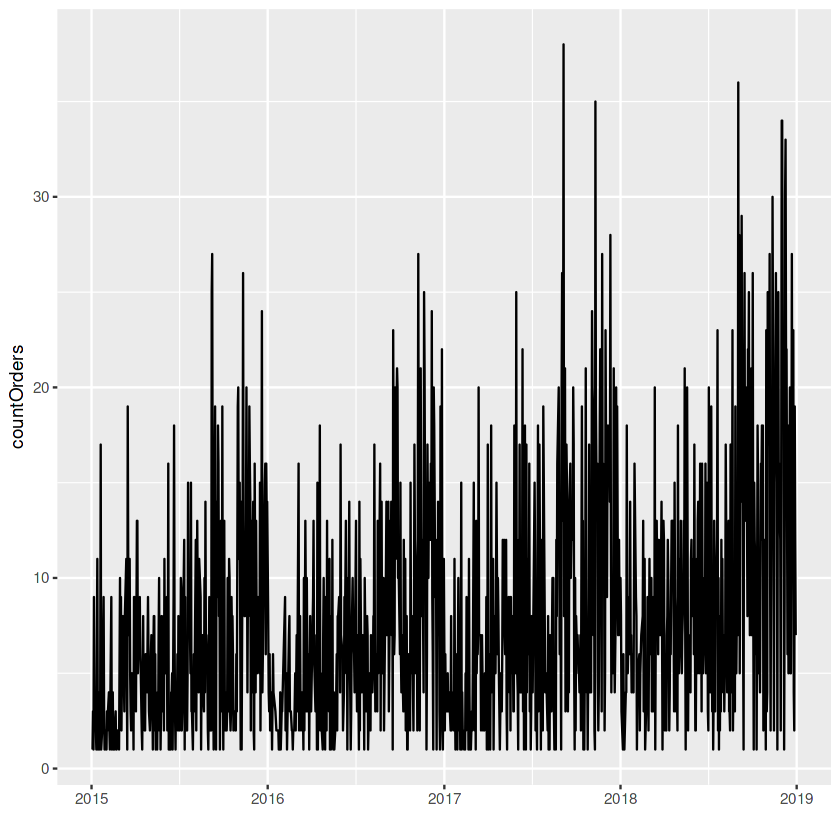

In [9]:
p <- ggplot(Count_ofOrdersDay, aes(x=Order_Date, y=countOrders)) +
  geom_line() + 
  xlab("")
p

In this barplot we can see, Number of orders has same pattern in same month.

### Plotting Original Data by monthly grouping

In [10]:
Data_Sale_Monthly=as.data.table(Data_Sale[,c("Order_ID","Order_Date")])
Data_Sale_Monthly$first_day <- floor_date(ymd(Data_Sale_Monthly$Order_Date), 'month')
head(Data_Sale_Monthly[order(Order_Date),])

Order_ID,Order_Date,first_day
<chr>,<date>,<date>
OD3324,2015-01-03,2015-01-01
OD740,2015-01-04,2015-01-01
OD741,2015-01-04,2015-01-01
OD742,2015-01-04,2015-01-01
OD3873,2015-01-05,2015-01-01
OD3014,2015-01-06,2015-01-01


In [11]:
Count_ofOrders_Monthly=Data_Sale_Monthly[,.(countOrders=.N),.(first_day)]
head(Count_ofOrders_Monthly[order(first_day),])

first_day,countOrders
<date>,<int>
2015-01-01,79
2015-02-01,46
2015-03-01,157
2015-04-01,135
2015-05-01,122
2015-06-01,135


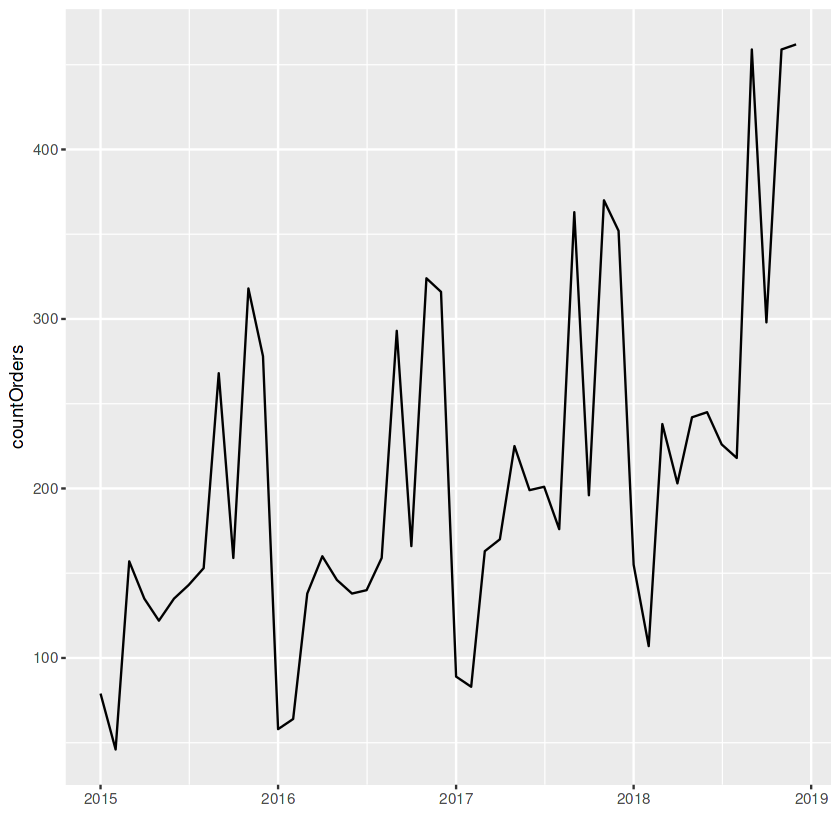

In [12]:
p_monthly <-  ggplot(Count_ofOrders_Monthly, aes(x=first_day, y=countOrders)) +
  geom_line() + 
  xlab("")
p_monthly

### Decompose dataset

# 3- Data Preparation

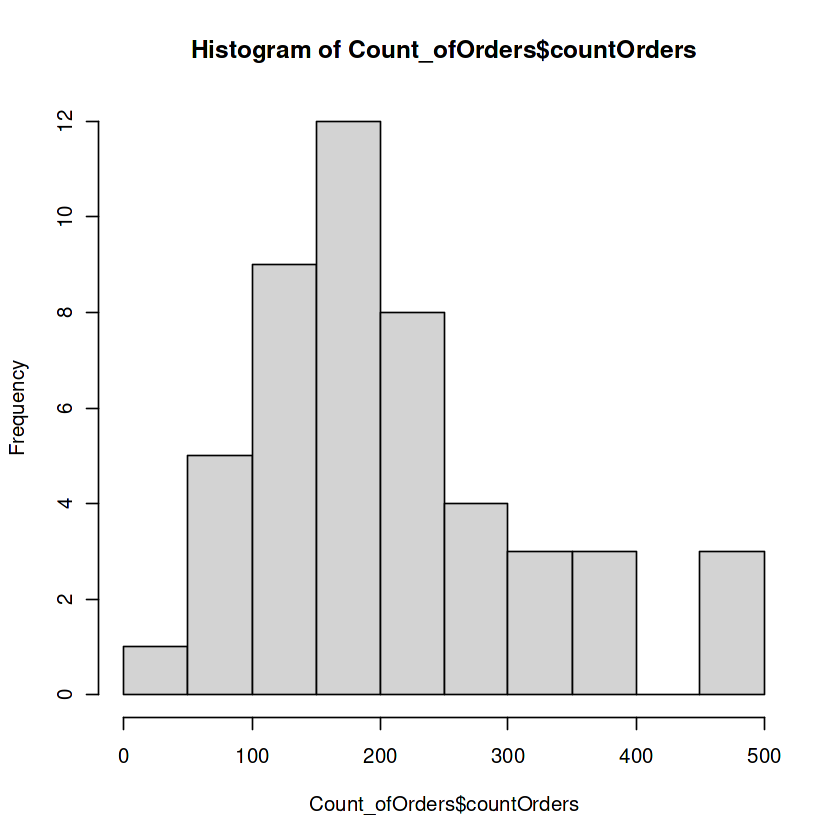

In [13]:
hist(Count_ofOrders$countOrders)

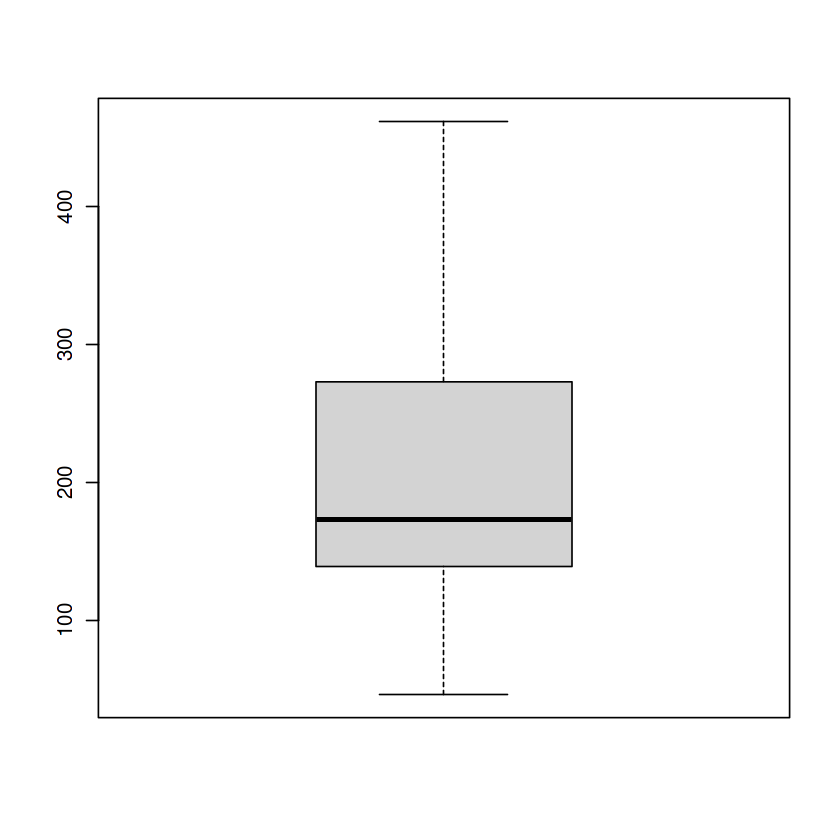

In [14]:
boxplot(Count_ofOrders$countOrders)

In [15]:
summary(Count_ofOrders$countOrders)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   46.0   139.5   173.0   208.2   270.5   462.0 

## 3.1 Generate time series object

In [16]:
#generate time series object with 12 frequency (month)
Count_ofOrders_sorted=Count_ofOrders[order(YYYYMM,decreasing = FALSE),]
NumberofOrders=Count_ofOrders_sorted$countOrders

tsSale=ts(NumberofOrders, start = c(2015, 1), frequency = 12)
min(Count_ofOrders$YYYYMM)
max(Count_ofOrders$YYYYMM)
tsSale

[1] "2015-01"

[1] "2018-12"

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2015,79,46,157,135,122,135,143,153,268,159,318,278
2016,58,64,138,160,146,138,140,159,293,166,324,316
2017,89,83,163,170,225,199,201,176,363,196,370,352
2018,155,107,238,203,242,245,226,218,459,298,459,462


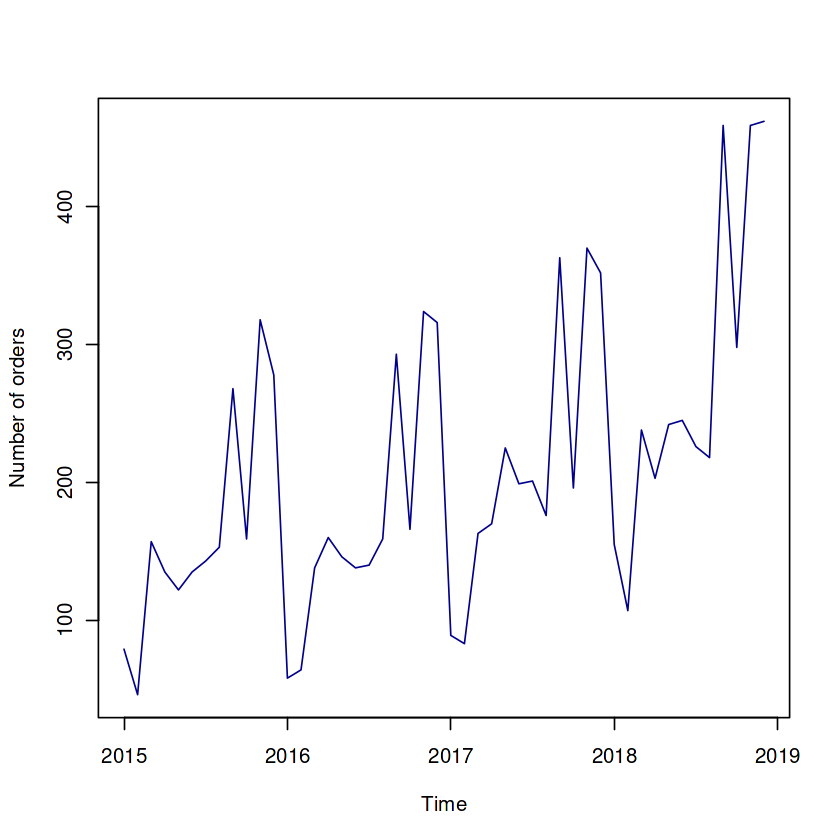

In [17]:
plot(tsSale, col="darkblue", ylab="Number of orders")

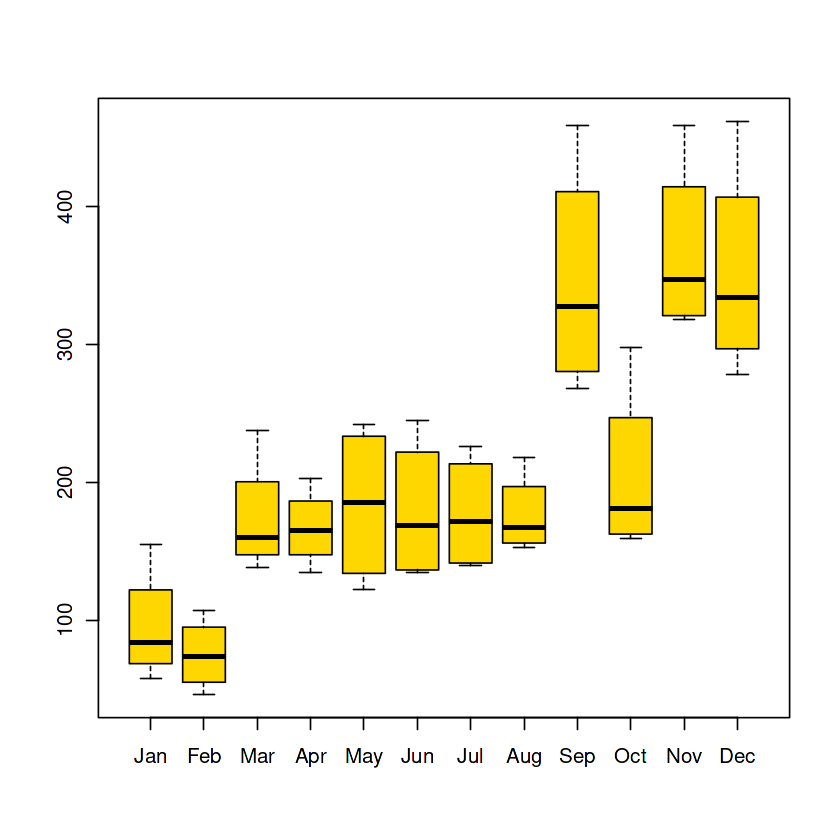

In [18]:
# plot the seasonal distribution of the series
boxplot(split(tsSale, cycle(tsSale)), names = month.abb, col = "gold")

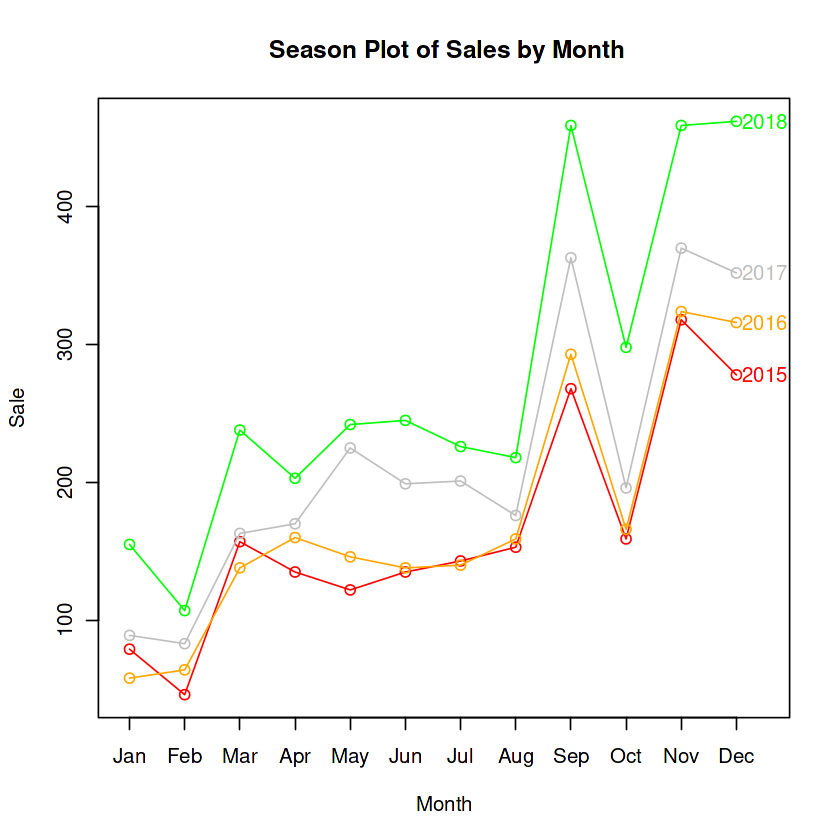

In [19]:
# Create a Season Plot
seasonplot(tsSale, year.labels = "TRUE", main = " Season Plot of Sales by Month", 
           xlab = "Month", ylab = "Sale", 
           col = c("red", "orange", "gray", "green", "blue", "purple", "black"))

From the above plot, you can see that number of sale hase similar pattern in same month in difference year.

## Decomposing the dataset

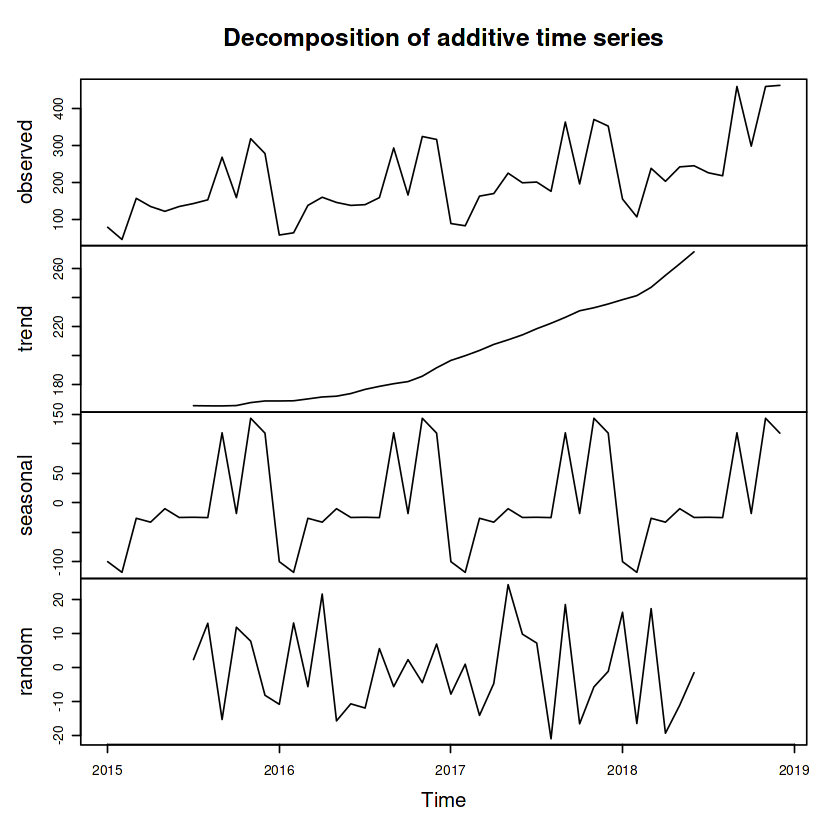

In [20]:
# Decompose the time series
decomposition <- decompose(tsSale)


# Access the decomposed components
trend <- decomposition$trend
seasonal <- decomposition$seasonal
remainder <- decomposition$residual

# Plot the decomposed components (optional)
plot(decomposition)

## 3.2 Log transform a time series

The time series data has a skewed distribution so I used log transformation, ARIMA models work best with normally distributed residuals.

In [21]:
# Transform time series to log scale
ltSale <- log(tsSale)
ltSale

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2015,4.369448,3.828641,5.056246,4.905275,4.804021,4.905275,4.962845,5.030438,5.590987,5.068904,5.762051,5.627621
2016,4.060443,4.158883,4.927254,5.075174,4.983607,4.927254,4.941642,5.068904,5.680173,5.111988,5.780744,5.755742
2017,4.488636,4.418841,5.093750,5.135798,5.416100,5.293305,5.303305,5.170484,5.894403,5.278115,5.913503,5.863631
2018,5.043425,4.672829,5.472271,5.313206,5.488938,5.501258,5.420535,5.384495,6.129050,5.697093,6.129050,6.135565


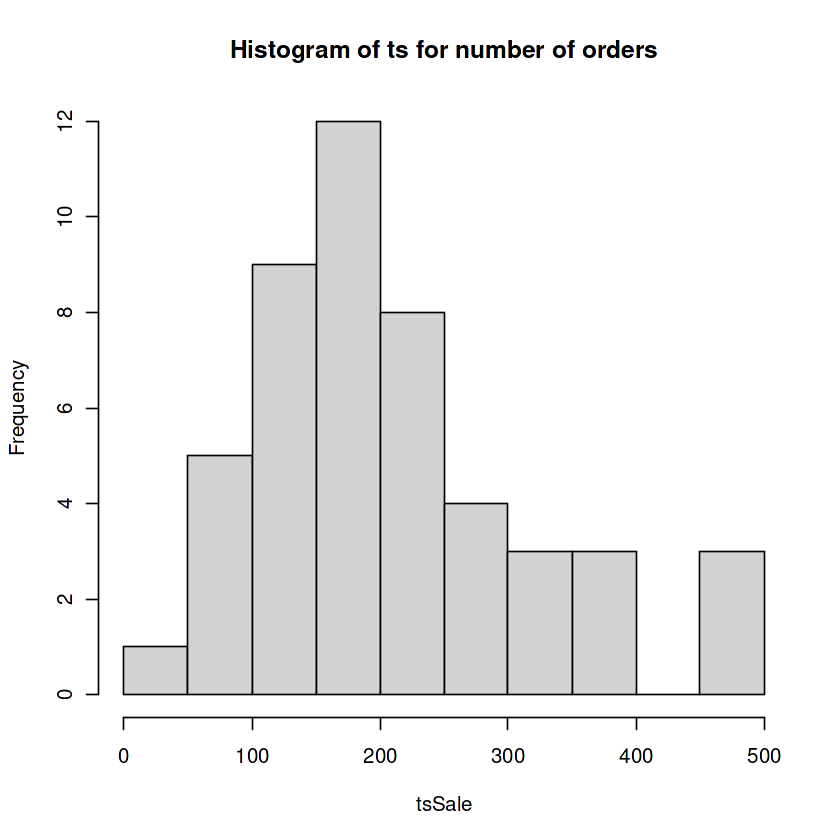

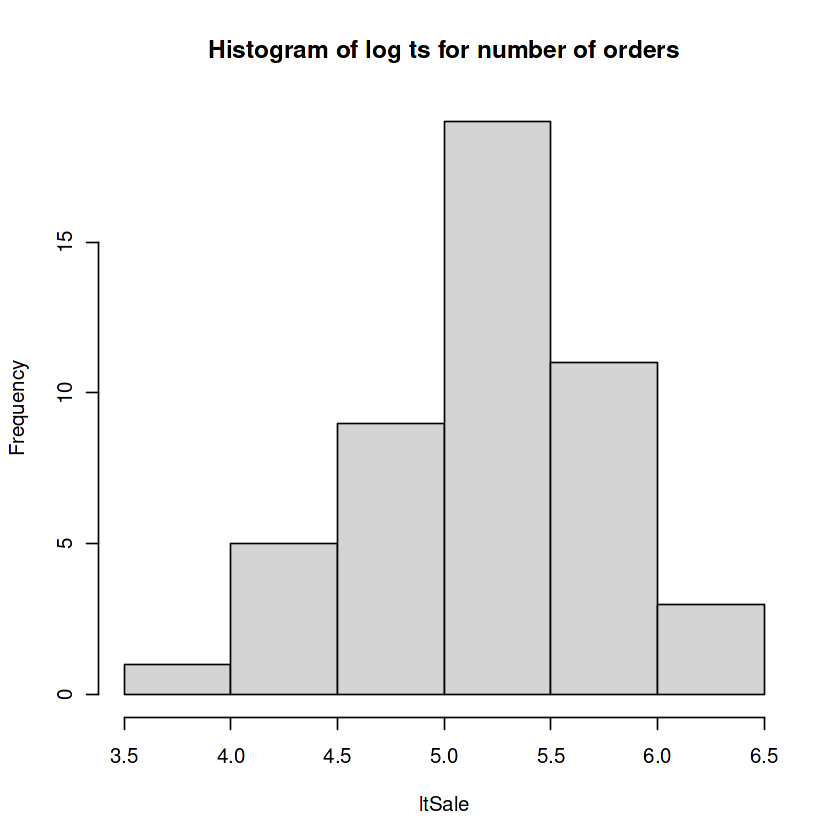

In [22]:
#histogram
hist(tsSale, main="Histogram of ts for number of orders",)
hist(ltSale , main="Histogram of log ts for number of orders",)

The histogram clearly shows the series becomes more normal after the log transform.

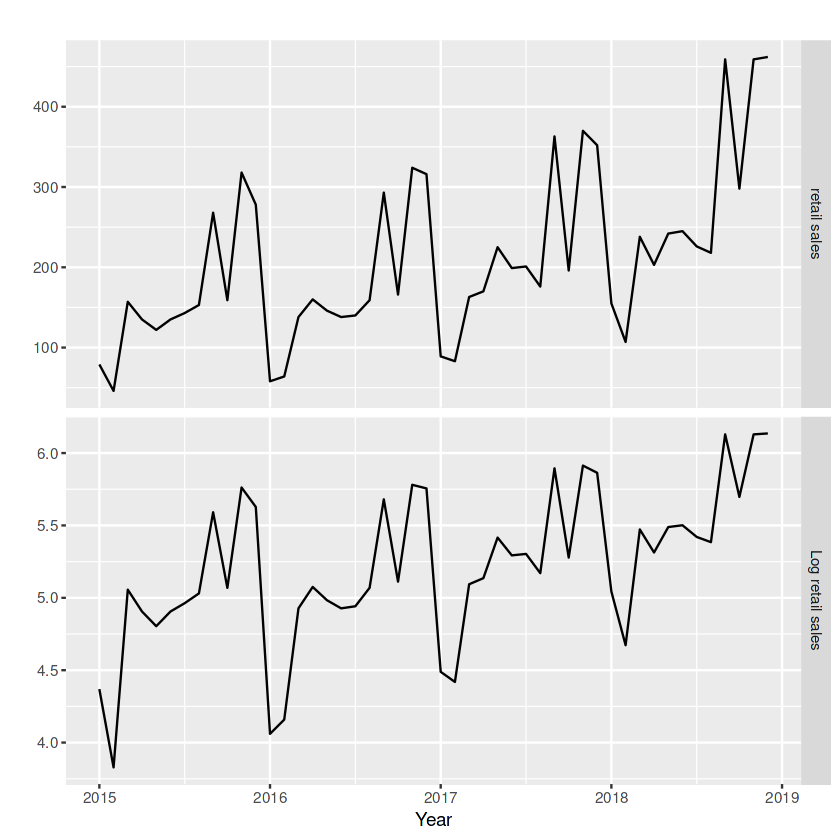

In [23]:
cbind("retail sales" = tsSale,
      "Log retail sales"=ltSale) %>%
  autoplot(facets=TRUE) + xlab("Year") + ylab("")

## 3.3 Sampling

The size of the test set is typically about 20% of the total sample

So, I split the log series in a training set and a test set

In [24]:
### training set
### use data from 2015 to 217 for forecasting
TrainLogSr = window(ltSale, start=2015, end=c(2017,12))

### test set
### use remaining data from 2018 to 2018 to test accuracy
TestLogSr = window(ltSale, start=2018, end=c(2018,12))


# 4. Auto Arima model

## 4.1 Createing Model

In [25]:
auto.arima(TrainLogSr, trace=TRUE)


 ARIMA(2,1,2)(1,1,1)[12]                    : Inf
 ARIMA(0,1,0)(0,1,0)[12]                    : -2.009504
 ARIMA(1,1,0)(1,1,0)[12]                    : -5.542224
 ARIMA(0,1,1)(0,1,1)[12]                    : -8.341769
 ARIMA(0,1,1)(0,1,0)[12]                    : -10.19204
 ARIMA(0,1,1)(1,1,0)[12]                    : -8.341756
 ARIMA(0,1,1)(1,1,1)[12]                    : Inf
 ARIMA(1,1,1)(0,1,0)[12]                    : -8.177551
 ARIMA(0,1,2)(0,1,0)[12]                    : -8.083906
 ARIMA(1,1,0)(0,1,0)[12]                    : -8.136127
 ARIMA(1,1,2)(0,1,0)[12]                    : -5.915856

 Best model: ARIMA(0,1,1)(0,1,0)[12]                    



Series: TrainLogSr 
ARIMA(0,1,1)(0,1,0)[12] 

Coefficients:
          ma1
      -0.7699
s.e.   0.1440

sigma^2 = 0.03096:  log likelihood = 7.4
AIC=-10.79   AICc=-10.19   BIC=-8.52

In [26]:
arimaModLog <- auto.arima(TrainLogSr, stepwise=FALSE, approximation=FALSE)
arimaModLog

Series: TrainLogSr 
ARIMA(0,1,1)(0,1,0)[12] 

Coefficients:
          ma1
      -0.7699
s.e.   0.1440

sigma^2 = 0.03096:  log likelihood = 7.4
AIC=-10.79   AICc=-10.19   BIC=-8.52

## 4.2 Forecasting 12 Month

In [27]:

arimaModLog.Fr <-forecast(arimaModLog,h=12)
arimaModLog.Fr

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       4.664340 4.438846 4.889835 4.319476 5.009204
Feb 2018       4.594544 4.363160 4.825929 4.240672 4.948417
Mar 2018       5.269454 5.032325 5.506583 4.906797 5.632111
Apr 2018       5.311502 5.068765 5.554239 4.940268 5.682736
May 2018       5.591804 5.343586 5.840022 5.212187 5.971421
Jun 2018       5.469009 5.215427 5.722590 5.081190 5.856827
Jul 2018       5.479009 5.220176 5.737842 5.083158 5.874860
Aug 2018       5.346188 5.082207 5.610168 4.942465 5.749911
Sep 2018       6.070107 5.801077 6.339136 5.658662 6.481552
Oct 2018       5.453818 5.179833 5.727804 5.034794 5.872843
Nov 2018       6.089207 5.810354 6.368060 5.662738 6.515676
Dec 2018       6.039335 5.755698 6.322972 5.605549 6.473121

## 4.3 Visualize actual sale data and forcast 

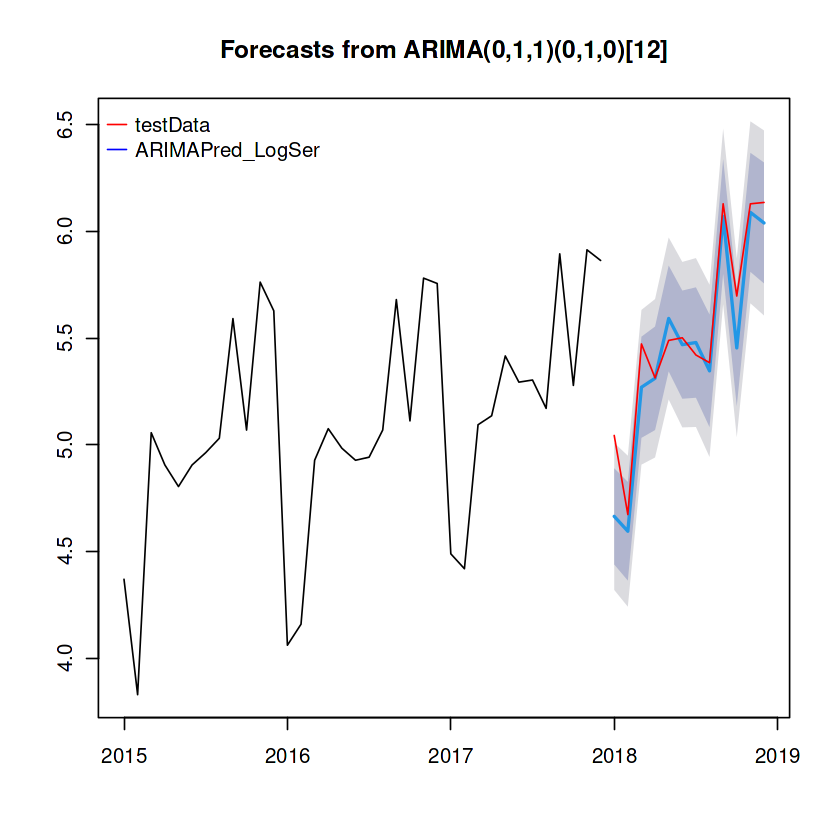

In [28]:
# plot of the test set and its prediction and prediction of future 12 months 
plot(arimaModLog.Fr)
lines(TestLogSr, col="red")
legend("topleft",lty=1,bty = "n",col=c("red","blue"),c("testData","ARIMAPred_LogSer"))



## 4.4 Evaluate Model

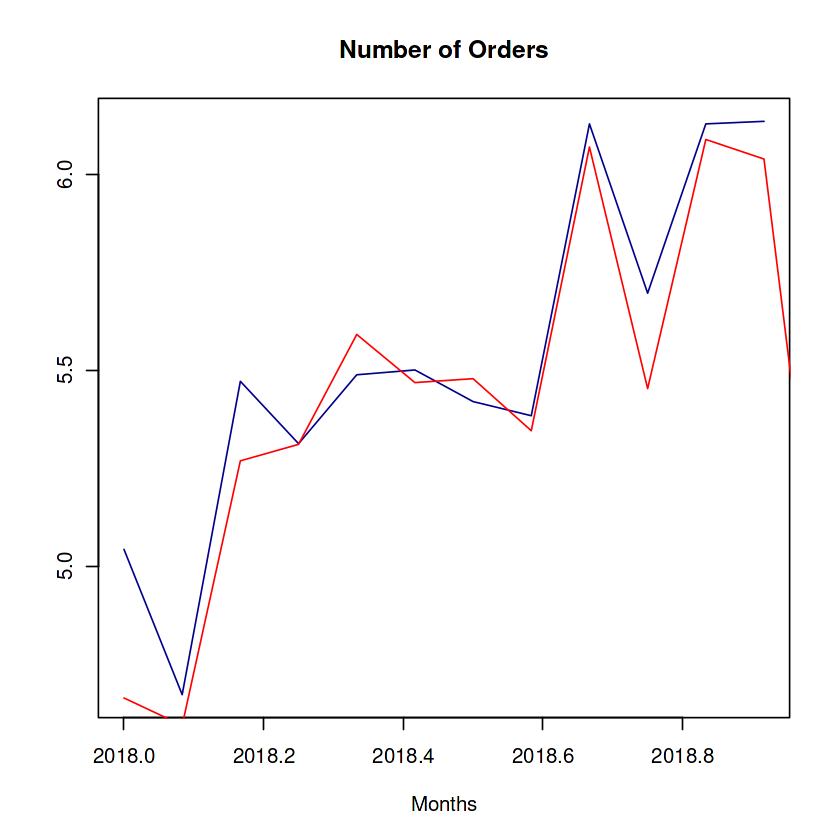

In [29]:
# plot of the test set and its prediction only
ARLog.mean <-forecast(arimaModLog,h=24)$mean
plot(TestLogSr, main="Number of Orders", ylab="", xlab="Months", col="darkblue")  
lines(ARLog.mean, col="red")

While a visual plot shows similar trends between actual and forecasted sales for each month, further evaluation metrics like RMSE are essential to confirm the model's overall accuracy for test data forecasting

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.03260101,0.1375496,0.08032617,0.7295502,1.642907,0.4507939,-0.03620993,NA
Test set,0.08411655,0.1530208,0.11100658,1.5604372,2.052573,0.6229736,0.08366428,0.2650899


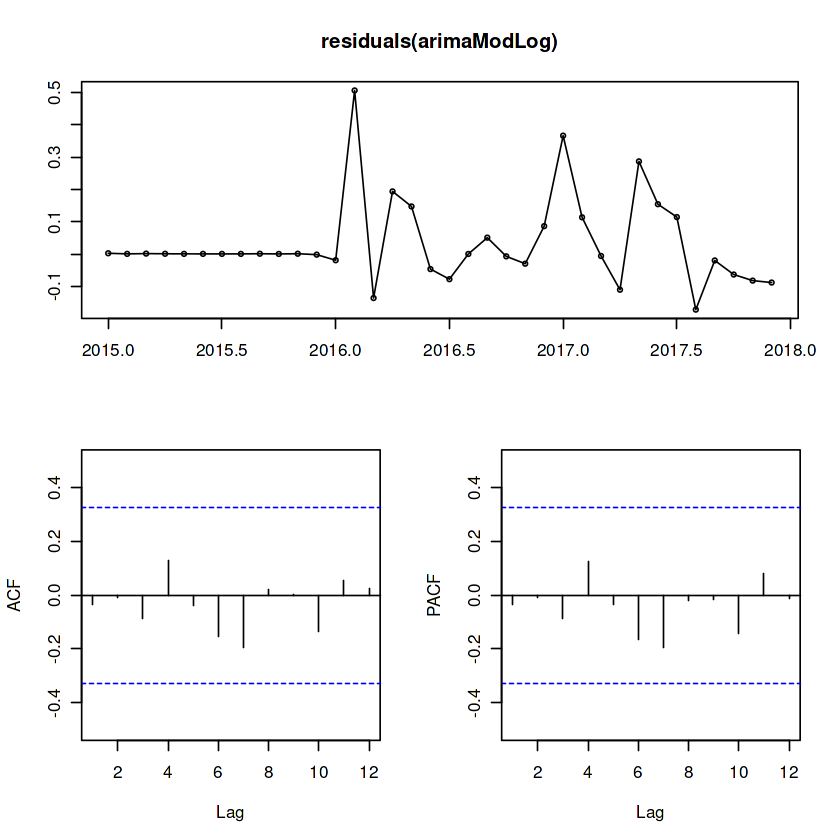

In [30]:
accuracy(arimaModLog.Fr,TestLogSr)

# test residues of arima
tsdisplay(residuals(arimaModLog))

The RMSE values are relatively low, indicating that the model's forecasts are reasonably close to the actual sales figures. As expected, the training set RMSE (0.1376) is slightly lower than the test set RMSE (0.1530). This is common, as the model is optimized to fit the training data. However, the difference is minor, suggesting the model generalizes well to unseen data (test set) as well.

In [31]:
# Best lag
# It is recommended using h=10 for non-seasonal data and h=2m for seasonal data, where m is the period of seasonality.
# for seasonality over 12 months, h = 2 * 12 = 24
lb <- Box.test(residuals(arimaModLog), lag = 24, type = "Ljung-Box")
lb


	Box-Ljung test

data:  residuals(arimaModLog)
X-squared = 14.015, df = 24, p-value = 0.9463


In [32]:
bp <- Box.test(residuals(arimaModLog), lag = 24, type = "Box-Pierce")
bp


	Box-Pierce test

data:  residuals(arimaModLog)
X-squared = 8.2931, df = 24, p-value = 0.9988


Both tests have very high p-values (0.9988 and 0.9463, respectively). A high p-value (typically above 0.05) indicates we can't reject the null hypothesis, which means there's no significant autocorrelation (dependence) in the residuals. This suggests the model's residuals behave like white noise, a desirable characteristic for a good time series model.


	Ljung-Box test

data:  Residuals from ARIMA(0,1,1)(0,1,0)[12]
Q* = 14.015, df = 23, p-value = 0.9264

Model df: 1.   Total lags used: 24



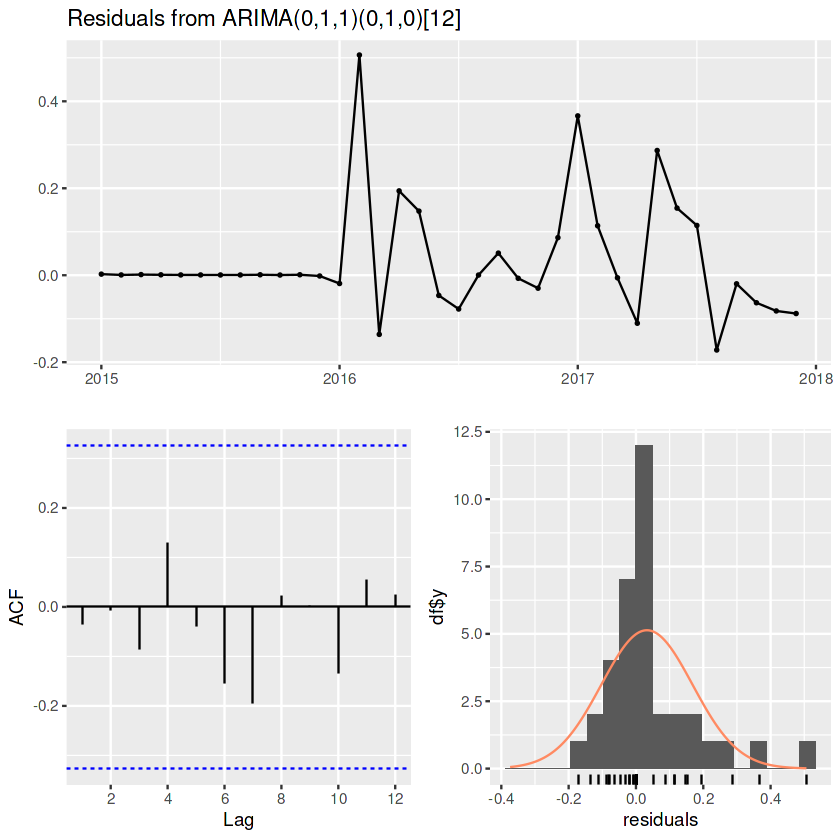

In [33]:
checkresiduals(arimaModLog, lag=24)

In [34]:
arimaModLog$aic # log Auto.ARIMA model

[1] -10.79204

The AIC value of -10.792044 is a good sign.  Lower AIC values indicate a better balance between model complexity and fit. 

Overall, these results strongly suggest that the ARIMA model is effective in forecasting retail sales. Thus, we now have a seasonal ARIMA model that passes the required checks and is ready for forecasting. 

## 4.6 Kpss test
the default value in auto.arima() is test="kpss". 

A KPSS test has a null hypothesis of stationarity.

The ‘number of retail sales’ series is not stationary, as it can be proved with the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. The null hypothesis of the test is that the series is stationary, so a p < 0.05 (the conventional threshold for rejecting the null, whatever this means) indicates that the series is not stationary.


In [35]:
library(tseries)

kpss.test(ltSale)

Warning message in kpss.test(ltSale):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  ltSale
KPSS Level = 0.79697, Truncation lag parameter = 3, p-value = 0.01


The test p-value = 0.01, so we can assume that the series is not stationary.

# 5. Forecast for next 36 month
Forecasts from the model for the next three years are shown in below.

In [36]:
arimaModLog_Full <- auto.arima(ltSale, stepwise=FALSE, approximation=FALSE)
arimaModLog_Full

Series: ltSale 
ARIMA(0,1,1)(0,1,0)[12] 

Coefficients:
          ma1
      -0.8121
s.e.   0.0976

sigma^2 = 0.02755:  log likelihood = 13.17
AIC=-22.33   AICc=-21.96   BIC=-19.22

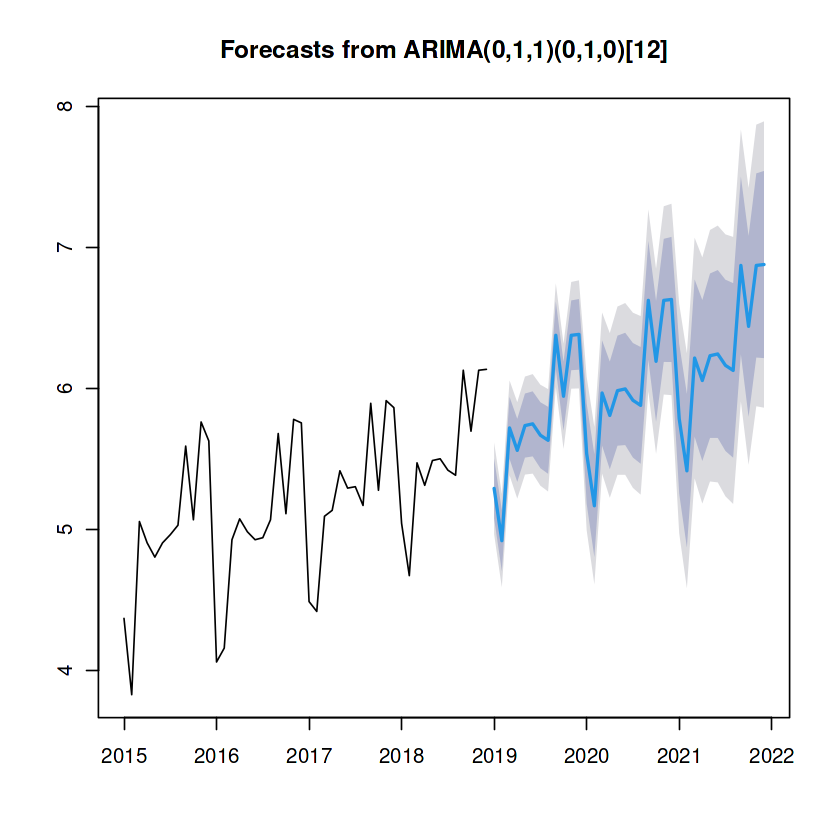

In [37]:
arimaModLog.Fr.3Years <-forecast(arimaModLog_Full,h=36)
plot(arimaModLog.Fr.3Years)